In [1]:
if 'google.colab' in str(get_ipython()):
    !pip uninstall tensorflow -y
    !pip install tensorflow==2.3.1 tensorflow-quantum
    !rm -rf quantum-gans
    !git clone https://github.com/WiktorJ/quantum-gans
    !cd quantum-gans; pip install .

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import math
import random
import tensorflow as tf

import cirq
import numpy as np
from qsgenerator.utils import map_to_radians
from qsgenerator.qugans import circuits
from qsgenerator.qugans.training import Trainer
from qsgenerator.phase.circuits import build_ground_state_circuit
from qsgenerator.phase.analitical import  get_ground_state_for_g
from qsgenerator.states.simple_state_circuits import build_x_rotation_state
from qsgenerator.states.simple_rotation_generators import get_binary_x_rotation_provider, get_arcsin_x_rotation_provider
from qsgenerator.phase.analitical import construct_hamiltonian, get_theta_v, get_theta_w, get_theta_r, get_g_parameters_provider
from qsgenerator.evaluators.circuit_evaluator import CircuitEvaluator

In [88]:
generator_layers = 3
discriminator_layers = 4
data_bus_size = 2

In [89]:
real_phase = False
generic_generator = True
all_layers_labeling = False
full_layer_labeling = False
use_gen_label_qubit = False

In [90]:
gen, gs, disc, ds, ls, data_qubits, out_qubit = circuits.build_gan_circuits(
    generator_layers, 
    discriminator_layers, 
    data_bus_size, 
    all_layers_labeling=all_layers_labeling,
    full_layer_labeling=full_layer_labeling,
    use_gen_label_qubit=use_gen_label_qubit)

In [91]:
if not generic_generator:
    gen, gs = build_ground_state_circuit(qubits=data_qubits, full_parametrization=True)

In [92]:
if real_phase:
    real, real_symbols = build_ground_state_circuit(qubits=data_qubits)
else:
    real, real_symbols = build_x_rotation_state(qubits=data_qubits)

In [93]:
pure_gen = gen.copy()
gen.append([disc])

In [94]:
pure_real = real.copy()
real.append([disc])

In [95]:
print("REAL GROUND STATE")
pure_real

REAL GROUND STATE


(0, 1): ───Rx(r0)───

(0, 2): ───Rx(r1)───

In [96]:
print("GENERATOR")
pure_gen

GENERATOR


(0, 1): ───Rx(g0)───Rz(g2)───ZZ──────Rx(g5)───Rz(g7)───ZZ──────Rx(g10)───Rz(g12)───ZZ───────
                             │                         │                           │
(0, 2): ───Rx(g1)───Rz(g3)───ZZ^g4───Rx(g6)───Rz(g8)───ZZ^g9───Rx(g11)───Rz(g13)───ZZ^g14───

In [97]:
print("DISCRIMINATOR")
disc

DISCRIMINATOR


(0, 0): ───Rx(d0)───Rz(d3)───ZZ──────────────Rx(d8)────Rz(d11)───ZZ────────────────Rx(d16)───Rz(d19)───ZZ────────────────Rx(d24)───Rz(d27)───ZZ────────────────
                             │                                   │                                     │                                     │
(0, 1): ───Rx(d1)───Rz(d4)───ZZ^d6───ZZ──────Rx(d9)────Rz(d12)───ZZ^d14───ZZ───────Rx(d17)───Rz(d20)───ZZ^d22───ZZ───────Rx(d25)───Rz(d28)───ZZ^d30───ZZ───────
                                     │                                    │                                     │                                     │
(0, 2): ───Rx(d2)───Rz(d5)───────────ZZ^d7───Rx(d10)───Rz(d13)────────────ZZ^d15───Rx(d18)───Rz(d21)────────────ZZ^d23───Rx(d26)───Rz(d29)────────────ZZ^d31───

In [98]:
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([0] * len(gs)) + \
                   np.random.normal(scale=eps, size=(len(gs),))
init_disc_weights = np.random.normal(size=(len(ds),))

gen_weights = tf.Variable(init_gen_weights, dtype=tf.float32)
disc_weights = tf.Variable(init_disc_weights, dtype=tf.float32)

In [99]:
class CustomScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps=4000):
        super(CustomScheduler, self).__init__()
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        return max(math.e ** - ((step+200) / (self.warmup_steps / math.log(100))), 0.01)

In [100]:
learning_rate = CustomScheduler()

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [101]:
g_values = [0.1]
# x_rotations = get_binary_x_rotation_provider({0: '100', 1: '011', 2: '101'})
real_values_provider = get_arcsin_x_rotation_provider(g_values, data_bus_size)
#real_values_provider = get_g_parameters_provider()

In [102]:
trainer = Trainer(g_values, 
                  data_bus_size, 
                  disc, 
                  gen, 
                  real, 
                  out_qubit, 
                  ds, 
                  gs, 
                  real_symbols, 
                  ls,
                  real_values_provider = real_values_provider,
                  use_analytical_expectation=True)

<Figure size 432x288 with 0 Axes>

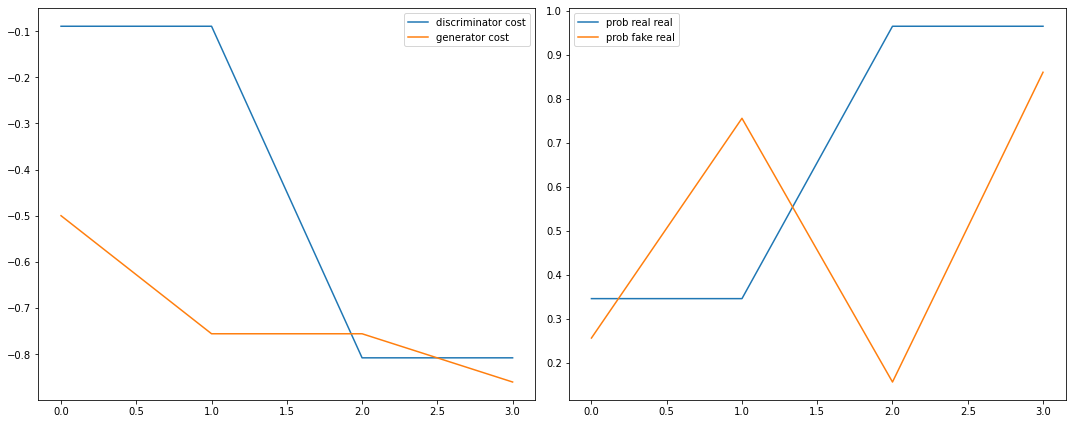

In [ ]:
epochs = 5
disc_iteration = 20
gen_iteration = 5
snapshot_interval_epochs = 20
results = trainer.train(disc_weights,
      gen_weights, 
      opt, 
      epochs=epochs, 
      disc_iteration=disc_iteration, 
      gen_iteration=gen_iteration,
      snapshot_interval_epochs=snapshot_interval_epochs)

In [ ]:
def get_gen_for_g(g, gen_weights):
    rad = map_to_radians(g)
    return np.append(gen_weights, rad)

def get_states_and_fidelty_for_real(gen_evaluator, 
                                    real_evaluator, 
                                    gen_weights, 
                                    g, 
                                    size, 
                                    real_provider):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights))
    real = real_evaluator.get_state_from_params(real_provider(g))
    return generated, real, cirq.fidelity(generated, real)

def get_states_and_fidelty_for_ground(gen_evaluator, g, gen_weights, size):
    generated = gen_evaluator.get_state_from_params(get_gen_for_g(g, gen_weights), list(range(size)))
    ground = get_ground_state_for_g(g, size)
    return generated, ground, cirq.fidelity(generated, ground)

def compare_generated_for_g(gen_evaluator, g1, g2, gen_weights, size):
    generated1 = gen_evaluator.get_state_from_params(get_gen_for_g(g1, gen_weights), list(range(size)))
    generated2 = gen_evaluator.get_state_from_params(get_gen_for_g(g2, gen_weights), list(range(size)))
    return generated1, generated2, cirq.fidelity(generated1, generated2)

In [ ]:
trained_disc_weights = tf.Variable(np.array([ 1.25888796e+01,  1.10409822e+01,  1.27487049e+01,  1.32927475e+01,
       -3.20522385e+01,  2.98508596e+00, -7.54223883e-01,  8.97036648e+00,
        8.98472309e+00, -2.77423954e+00,  8.90891266e+00,  5.72837019e+00,
        6.03105211e+00, -4.64482594e+00, -1.10843427e-01,  7.78598115e-02,
        3.00343895e+00,  3.83781940e-01,  6.08641243e+00,  8.64131927e+00,
       -2.17593918e+01,  1.45857897e+01,  2.36893883e+01,  8.75363445e+00,
       -2.42768993e+01,  1.27688437e+01,  2.53628349e+00,  1.39768391e+01,
        1.40961084e+01, -2.04474068e+01,  4.71392822e+00,  1.66926212e+01,
        1.88311214e+01,  9.17525005e+00,  1.16109962e+01,  1.08004580e+01,
        1.10795708e+01,  5.81477690e+00, -5.50215101e+00,  2.22007637e+01,
        2.25015125e+01,  3.21826210e+01, -1.80058708e+01, -7.85126591e+00,
       -7.77073908e+00,  1.40237570e+01,  3.14071465e+01, -1.07477732e+01,
        1.55852342e+00,  2.63786411e+01,  1.31890945e+01,  7.14759350e+00,
        5.46145630e+00, -1.79730053e+01,  7.40563774e+00,  1.06135674e+01,
       -1.55095673e+00, -2.66580944e+01,  6.51995277e+00, -2.37151980e+00,
        3.51896515e+01,  1.50027342e+01,  1.80733763e-02, -1.75052185e+01,
        9.60706902e+00, -6.06413984e+00,  5.35433817e+00, -7.88707399e+00,
        1.27363043e+01,  1.02446747e+01]), dtype=tf.float32)

trained_gen_weights = np.array([
      -0.20239973068237305,
      4.103419780731201,
      4.835892677307129,
      -5.277573585510254,
      7.324734210968018,
      -0.006883351132273674,
      -5.015811920166016,
      -12.468819618225098,
      -2.2864558696746826,
      6.433105945587158,
      6.776863098144531,
      -4.772155284881592,
      -4.78993034362793,
      -8.97536563873291
    ])
gen_symbols = gs 
# gen_symbols = gs
# real_symbols = ('r0', 'r1', 'r2')

In [166]:
gen_evaluator = CircuitEvaluator(pure_gen, gen_symbols)
real_evaluator = CircuitEvaluator(pure_real, real_symbols)
x_rotations(g)

[0.2003348423231196,
 0.4027158415806616,
 0.609385308030795,
 0.8230336921349761,
 1.0471975511965976]

In [ ]:
g=0.1
generated = gen_evaluator.get_state_from_params(trained_gen_weights)
real = real_evaluator.get_state_from_params(x_rotations(g))
generated, real, cirq.fidelity(generated, real)

In [ ]:
g = 0.1
real_evaluator.get_state_from_params(x_rotations(g))

In [ ]:
g = 0.1
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, x_rotations)

In [ ]:
g = -1
get_states_and_fidelty_for_real(gen_evaluator, real_evaluator, trained_gen_weights, g, data_bus_size, get_g_parameters_provider())

In [ ]:
compare_generated_for_g(gen_evaluator, -0.9, -0.8, trained_gen_weights, data_bus_size)

In [ ]:
g = 0
get_states_and_fidelty_for_ground(gen_evaluator, g, trained_gen_weights, data_bus_size)